In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
session_info = {'date': "15_01_2024",
                'genotype_dir': 'ER4d_sytjGCaMP7f_attp2',
                'fly': 'fly1',
                'session': 'closed_loop-000',
                'full_genotype': '+/w-; +/ER4d-AD; UAS-sytjGCaMP7f^{attp2}/ER4d-DBD (SS00238)',
                'ecl date': '' }

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_base_dir = fictrac_folder)



In [3]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=2, overwrite=False)


In [5]:
data = pp.data

In [27]:
print(pp.h5path_raw)
print(pathlib.Path(pp.h5path_raw.with_suffix('').as_posix() + '_append.h5'))
print(pp.h5path_raw.parent)


/media/mplitt/SSD_storage/2P_scratch/ER4d_sytjGCaMP7f_attp2/15_01_2024/fly1/closed_loop-000/data.h5
/media/mplitt/SSD_storage/2P_scratch/ER4d_sytjGCaMP7f_attp2/15_01_2024/fly1/closed_loop-000/data_append.h5
/media/mplitt/SSD_storage/2P_scratch/ER4d_sytjGCaMP7f_attp2/15_01_2024/fly1/closed_loop-000


In [28]:
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)

In [29]:
pp.align_voltage_recording()

In [30]:
pp.h5path_motcorr

PosixPath('/media/mplitt/SSD_storage/2P_scratch/ER4d_sytjGCaMP7f_attp2/15_01_2024/fly1/closed_loop-000/data_motcorr.h5')

In [31]:
nap = pp.open_napari()

In [18]:
nap.make_phase_masks()
pp.get_layers(nap)

In [89]:
pp.extract_timeseries()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '_datamdataodatatdatacdataodatardatardata.datahdata5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [29]:
pp.timeseries.keys()

dict_keys(['inner_ring', 'outer_ring', 'background', 'rois'])

In [62]:
y = pp.calculate_zscored_F('rois')

In [75]:
y_sm = sp.ndimage.gaussian_filter1d(y, 2, axis=-1)

In [86]:
x_f,y_f = st2p.utilities.pol2cart(y_sm[0,:,:],np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
print(rho.shape, phi.shape)

heading = pp.voltage_recording_aligned[' Heading'].to_numpy()
_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

(2836,) (2836,)


Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')


(array([255., 216., 406., 430., 299., 341., 215., 229., 243., 202.]),
 array([-3.13647016e+00, -2.50870942e+00, -1.88094868e+00, -1.25318793e+00,
        -6.25427193e-01,  2.33354940e-03,  6.30094291e-01,  1.25785503e+00,
         1.88561578e+00,  2.51337652e+00,  3.14113726e+00]),
 <BarContainer object of 10 artists>)

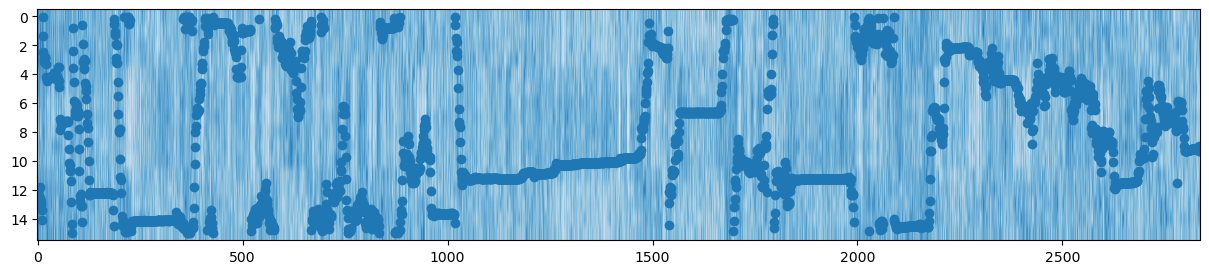

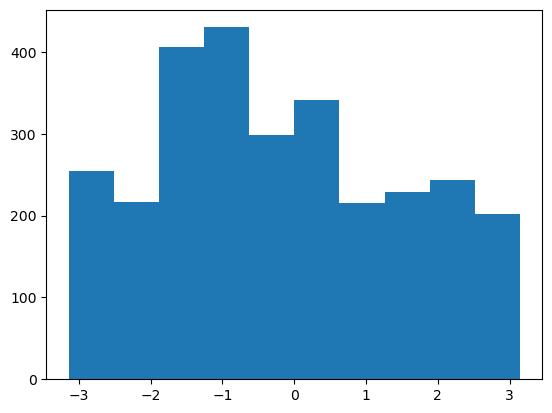

In [88]:
fig, ax= plt.subplots(figsize=[15,3])
ax.imshow(y[0,:,:], aspect='auto', cmap= 'Blues')
# ax.scatter(np.arange(y.shape[-1]), 15*(phi+np.pi)/2/np.pi)

print(pp.voltage_recording_aligned.columns)
# fig, ax= plt.subplots()
ax.scatter(np.arange(y.shape[-1]),15*( pp.voltage_recording_aligned[' Heading']+np.pi)/2/np.pi)

fig, ax= plt.subplots()
ax.hist(offset)

In [35]:
y = np.log(pp.timeseries['rois'])

In [38]:
print(pp.timeseries['background'].shape)

(1, 1, 2836)


In [39]:
X = []
X.append(np.array(pp.metadata['frame_times']).mean(axis=-1))
X.append(np.log(np.ravel(pp.timeseries['background'])))
X = np.column_stack(X)

In [44]:
from sklearn.linear_model import LinearRegression as LinReg

lr = LinReg().fit(X, np.squeeze(y).T)
y = np.squeeze(y).T - lr.predict(X)


In [51]:
z = sp.stats.zscore(np.exp(y).T, axis=-1)

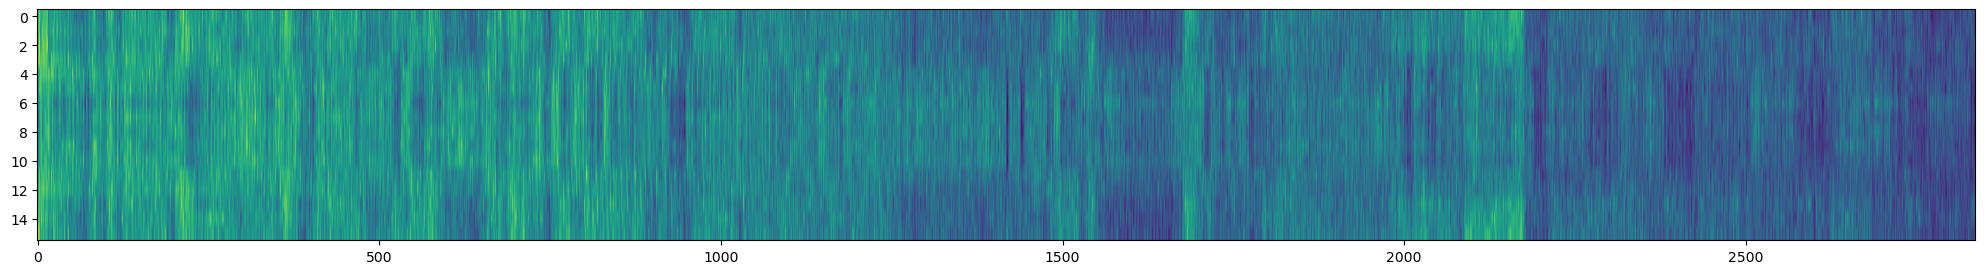

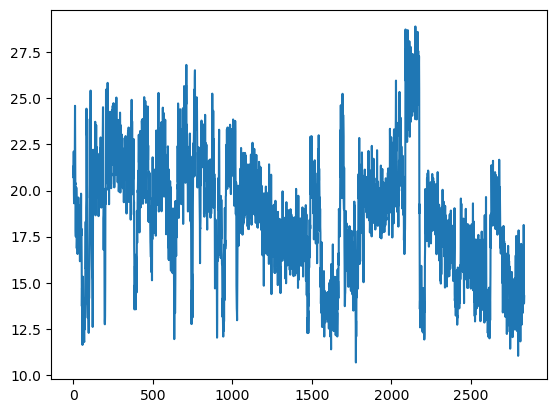

In [60]:
fig, ax = plt.subplots(figsize=[25,3])
ax.imshow(sp.stats.zscore(pp.timeseries['rois'][0,:,:],axis=-1), aspect='auto')

fig, ax = plt.subplots()
ax.plot(pp.timeseries['background'][0,0,:])

In [24]:
pp.save()